## Instacart Market Basket Analysis
In this notebook, we explore the data and ask questions, then seek to answer some of the questions using Pandas & Numpy. This is an initial analysis, therefore the findings are tentative.

* [Create big merged dataframe](#Create-big-merged-dataframe-with-orders-&-departments)
* [Take a first look at the data](#Take-a-first-look-at-the-data)
* ["Missing" Department](#"Missing"-department)
* [When items are ordered](#When-items-are-ordered)
* [Gone Bananas!](#Gone-Bananas!)
* [Creating Features](#Creating-Features)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

color = sns.color_palette()
sns.set()

Some initial questions:
* What are the most popular items purchased by prior customers?
* What are the most popular departments?
* What days of the week and hour of the day have the most orders?
* What are the most reordered items?

## Create big merged dataframe with item order history and other information

In [2]:
order_products_train = pd.read_csv("Data/order_products__train.csv")
order_products_prior = pd.read_csv("Data/order_products__prior.csv")
orders = pd.read_csv("Data/orders.csv")
products = pd.read_csv("Data/products.csv")
aisles = pd.read_csv("Data/aisles.csv")
departments = pd.read_csv("Data/departments.csv")

In [3]:
merge_prior = pd.merge(order_products_prior, products, how='left', on='product_id')
merge_prior = pd.merge(merge_prior, departments, how='left', on='department_id')
merge_prior = pd.merge(merge_prior, orders, how='inner', on='order_id')
merge_prior = pd.merge(merge_prior, aisles, how='inner', on='aisle_id')

## Take a first look at the data and answer initial questions

In [4]:
merge_prior.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'department', 'user_id',
       'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'aisle'],
      dtype='object')

In [5]:
len(merge_prior) # Total number of items in prior dataset, > 32M

32434489

In [22]:
merge_prior.info() # Checking that numeric column types are numeric

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 15 columns):
order_id                  int64
product_id                int64
add_to_cart_order         int64
reordered                 int64
product_name              object
aisle_id                  int64
department_id             int64
department                object
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
aisle                     object
dtypes: float64(1), int64(10), object(4)
memory usage: 5.1+ GB


In [6]:
merge_prior['product_name'].value_counts(dropna=False)[0:10]

Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584
Organic Avocado           176815
Large Lemon               152657
Strawberries              142951
Limes                     140627
Organic Whole Milk        137905
Name: product_name, dtype: int64

The top 9 most ordered items are all fresh produce, followed by fresh milk.

In [7]:
merge_prior['department'].value_counts(dropna=False)[0:10]

produce            9479291
dairy eggs         5414016
snacks             2887550
beverages          2690129
frozen             2236432
pantry             1875577
bakery             1176787
canned goods       1068058
deli               1051249
dry goods pasta     866627
Name: department, dtype: int64

In [27]:
merge_prior['department'].describe()

count     32434489
unique          21
top        produce
freq       9479291
Name: department, dtype: object

In [8]:
(merge_prior['department'].value_counts()[0] + merge_prior['department'].value_counts()[1])/len(merge_prior)

0.45918118210525838

45.9% of all the prior items ordered are categorized as either produce or dairy eggs!

## "Missing" department

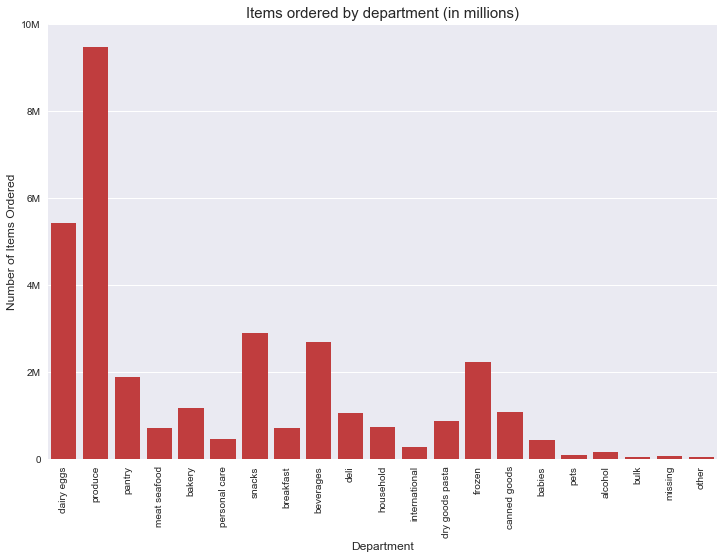

In [26]:
plt.figure(figsize=(12,8))
sns.countplot(x="department", data=merge_prior, color=color[3])
plt.ylabel('Number of Items Ordered', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.xticks(rotation='vertical')
plt.yticks([0, 2000000, 4000000, 6000000, 8000000, 10000000], ['0', '2M', '4M', '6M', '8M', '10M'])
plt.title("Items ordered by department (in millions)", fontsize=15)
plt.show()

Above we see a histogram of the "department" column from the prior items sold. There's also a category called "missing." Let's take a closer look at it.

In [29]:
missing_dept = merge_prior[merge_prior['department'] == 'missing']
missing_dept.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
31079504,75,44077,13,0,Tomato Basil Bisque Soup,100,21,missing,106387,prior,1,5,19,NaN,missing
31079505,154,41801,3,1,Cold Pressed Watermelon & Lemon Juice Blend,100,21,missing,73310,prior,68,6,19,0.0,missing
31079506,154,11806,4,0,Paleo Blueberry Muffin,100,21,missing,73310,prior,68,6,19,0.0,missing
31079507,420,7456,4,0,Organic Poblano Pepper,100,21,missing,161762,prior,37,2,11,2.0,missing
31079508,501,3884,11,0,Organic Plain Unsweetened Nondairy Cashew Yogurt,100,21,missing,86142,prior,40,2,12,16.0,missing


In [30]:
len(missing_dept)

69145

In [33]:
missing_dept['aisle_id'].value_counts()

100    69145
Name: aisle_id, dtype: int64

In [34]:
missing_dept['product_name'].describe()

count                         69145
unique                         1255
top       Organic Riced Cauliflower
freq                           8366
Name: product_name, dtype: object

We have 69145 items categorized as "missing" depertment, all with the same "aisle_id" value. There are 1255 different products categorized this way. This is only 0.02% of the dataset, so its probably not worth attempting to fix at this time.

## When items are ordered

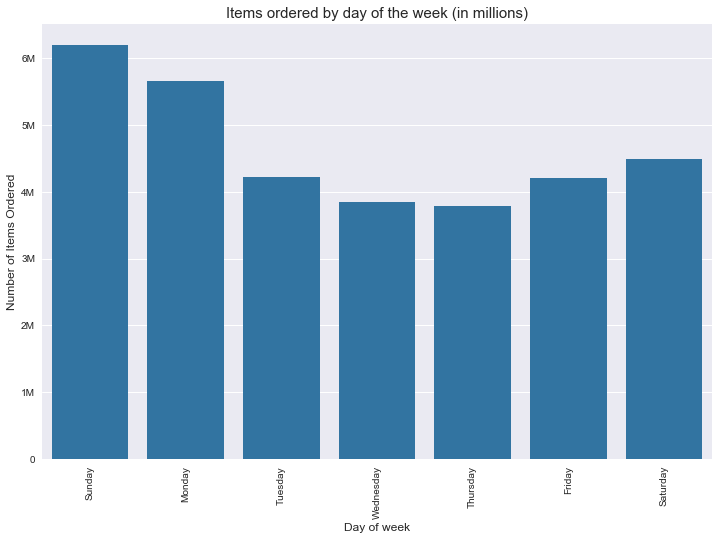

In [19]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=merge_prior, color=color[0])
plt.ylabel('Number of Items Ordered', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks([0, 1, 2, 3, 4, 5, 6],['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.xticks(rotation='vertical')
plt.yticks([0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000], ['0', '1M', '2M', '3M', '4M', '5M', '6M'])
plt.title("Items ordered by day of the week (in millions)", fontsize=15)
plt.show()

This chart shows that Sunday (0) and Monday (1) had the highest number of items ordered. Around 12 million total for those 2 days.

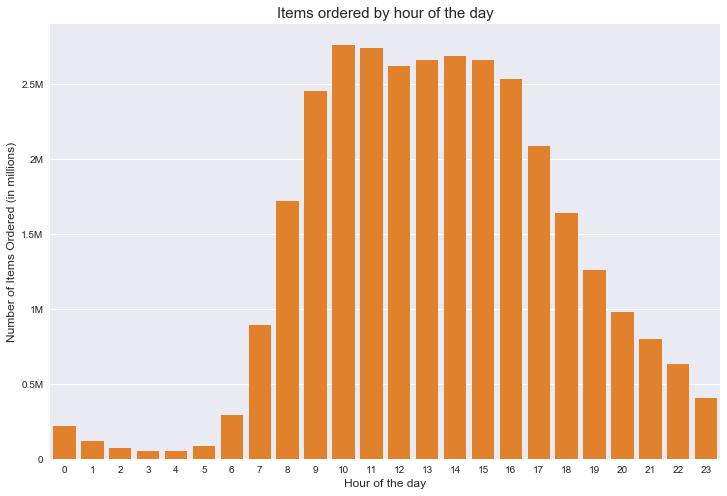

In [21]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=merge_prior, color=color[1])
plt.ylabel('Number of Items Ordered (in millions)', fontsize=12)
plt.xlabel('Hour of the day', fontsize=12)
plt.yticks([0, 500000, 1000000, 1500000, 2000000, 2500000], ['0', '0.5M', '1M', '1.5M', '2M', '2.5M'])
plt.title("Items ordered by hour of the day", fontsize=15)
plt.show()

Here we can see that most of the orders are placed between 9am and 5pm, with 10am to 12pm the busiest.

## Gone Bananas!

In [11]:
reordered_items = merge_prior[merge_prior['reordered'] == 1]
len(reordered_items) # Number of reordered items in prior dataset, ~ 19M

19126536

In [12]:
reordered_items['product_name'].value_counts()[:10]

Banana                    398609
Bag of Organic Bananas    315913
Organic Strawberries      205845
Organic Baby Spinach      186884
Organic Hass Avocado      170131
Organic Avocado           134044
Organic Whole Milk        114510
Large Lemon               106255
Organic Raspberries       105409
Strawberries               99802
Name: product_name, dtype: int64

The top 6 items are the same as with the full prior dataset.

We can see from the above list that there's some overlap in the way things are named. When ordering, you can choose "Banana," "Bananas," "Organic Banana," or "Bag of Organinc Bananas." Is "Banana" really a single banana, or is it a bunch or a "bag?" We can't tell fom this dataset, but we can see that bananas are very popular! Let's take a look at all of the items with the word "banana" in them. In all, we have around 875,000 produce bananas sold (top 3 items in the list below, plus "Bananas.")

In [23]:
banana_items = merge_prior['product_name'].str.contains('banana', case=False, na=False)
merge_prior[banana_items].product_name.value_counts()[:10]

Banana                                                     472565
Bag of Organic Bananas                                     379450
Organic Banana                                              18583
Organic YoKids Smoothie Strawberry Banana Lowfat Yogurt      7273
YoKids Strawberry Banana/Strawberry Yogurt                   6739
Bananas                                                      5140
Peach,  Apricot & Banana Stage 2 Baby Food                   5097
Organic Apple Banana GoGo Squeez                             4625
Yo Baby Organic Whole Milk Banana Mango Yogurt               4572
Baby Food Stage 2 Pumpkin Banana                             4460
Name: product_name, dtype: int64

There are even more choices when it comes to avocados as seen below.

In [24]:
avocado_items = merge_prior['product_name'].str.contains('avocado', case=False, na=False)
merge_prior[avocado_items].product_name.value_counts()[:10]

Organic Hass Avocado    213584
Organic Avocado         176815
Hass Avocados            50221
Small Hass Avocado       49021
Hass Avocado             17565
Avocado Roll              5885
Hass Avocado Bag          4770
Avocado                   4354
Hass Avocado Variety      4082
Spicy Avocado Hummus      3373
Name: product_name, dtype: int64

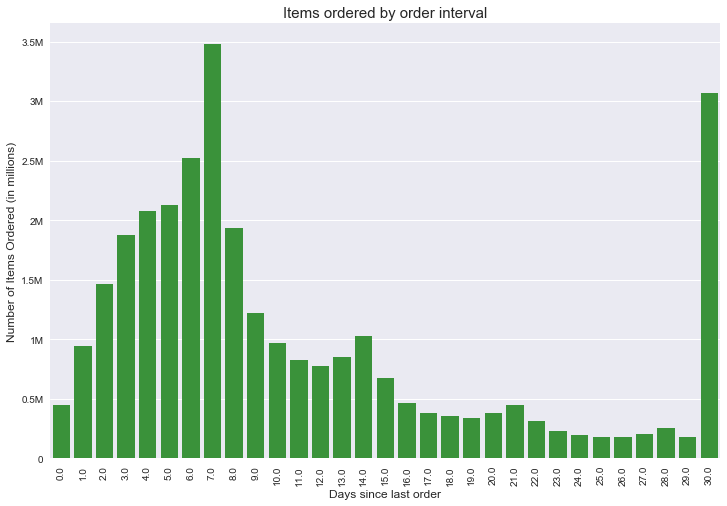

In [42]:
plt.figure(figsize=(12,8))
sns.countplot(x='days_since_prior_order', data=merge_prior, color=color[2])
plt.ylabel('Number of Items Ordered (in millions)', fontsize=12)
plt.xlabel('Days since last order', fontsize=12)
plt.xticks(rotation='vertical')
y_lab = ['0', '0.5M', '1M', '1.5M', '2M', '2.5M', '3M', '3.5M']
plt.yticks([0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000], y_lab)
plt.title("Items ordered by order interval", fontsize=15)
plt.show()

Here we can see that there's a spike in items ordered at 7 days since the last order, so in this dataset there seems to be several users that reorder weekly. The spike at 30 days may or may not be meaningful since 30 is the maximum value for this metric. 

There may be a large number of users that reorder monthly. If they have value 30, then we know they've ordered at least once before. If the value is zero, then I'll assume they placed an order, and soon thereafter thought of something they should have ordered and placed another order within the same day. There are missing values here too, so if the value is empty, I'll assume they are one-time users.

In [39]:
merge_prior['days_since_prior_order'].describe()

count    3.035642e+07
mean     1.110407e+01
std      8.778914e+00
min      0.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.500000e+01
max      3.000000e+01
Name: days_since_prior_order, dtype: float64

## Creating Features

In [55]:
reordered_items = merge_prior.groupby("order_id")["reordered"].sum().reset_index()
reordered_items["reordered"].loc[reordered_items["reordered"] > 1] = 1
reordered_items.reordered.value_counts() / len(reordered_items)

1    0.879151
0    0.120849
Name: reordered, dtype: float64

87.9% of prior orders have reordered items. Lets add columns to "merge prior" for the number of times an item was ordered, reordered, then one for a calculated reorder rate for that item.

In [44]:
prods = pd.DataFrame()
prods['orders'] = merge_prior.groupby(merge_prior.product_id).size().astype(np.int32)
prods['reorders'] = merge_prior['reordered'].groupby(merge_prior.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
merge_prior = merge_prior.join(prods, on='product_id')
del prods

merge_prior[:5]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,orders,reorders,reorder_rate
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,202279,prior,3,5,9,8.0,eggs,19400,13744.0,0.708454
1,22,23341,6,1,Large Grade AA Eggs,86,16,dairy eggs,30822,prior,25,1,8,12.0,eggs,6796,4115.0,0.605503
2,25,6383,7,1,All Whites 100% Egg Whites,86,16,dairy eggs,59897,prior,19,6,10,25.0,eggs,3390,2231.0,0.658112
3,26,33120,5,0,Organic Egg Whites,86,16,dairy eggs,153404,prior,2,0,16,7.0,eggs,19400,13744.0,0.708454
4,55,11520,12,0,Large Alfresco Eggs,86,16,dairy eggs,127522,prior,8,4,14,5.0,eggs,40376,31321.0,0.775733


Now we can build a users dataframe that aggregates information by user_id.

In [45]:
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['number_of_orders'] = orders.groupby('user_id').size().astype(np.int16)

users = pd.DataFrame()
users['total_items'] = merge_prior.groupby('user_id').size().astype(np.int16)
users['all_products'] = merge_prior.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)

users = users.join(usr)
del usr
users['average_basket'] = (users.total_items / users.number_of_orders).astype(np.float32)

users = users.reset_index()
users[:5]

,user_id,total_items,all_products,total_distinct_items,average_days_between_orders,number_of_orders,average_basket
0,1,59,"{17122, 14084, 26405, 196, 46149, 13032, 39657...",18,19.000000,11,5.363636
1,2,195,"{45066, 2573, 18961, 1559, 23, 32792, 22559, 1...",102,16.285715,15,13.000000
2,3,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33,12.000000,13,6.769231
3,4,18,"{21573, 42329, 17769, 22199, 35469, 37646, 265...",17,17.000000,6,3.000000
4,5,37,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",23,11.500000,5,7.400000


In [52]:
len(users) - len(users['user_id'].unique()) # All user_ids in dataframe are unique

0

In [53]:
users = users.set_index('user_id')
users[:5]

,total_items,all_products,total_distinct_items,average_days_between_orders,number_of_orders,average_basket
user_id,,,,,,
1,59,"{17122, 14084, 26405, 196, 46149, 13032, 39657...",18,19.000000,11,5.363636
2,195,"{45066, 2573, 18961, 1559, 23, 32792, 22559, 1...",102,16.285715,15,13.000000
3,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33,12.000000,13,6.769231
4,18,"{21573, 42329, 17769, 22199, 35469, 37646, 265...",17,17.000000,6,3.000000
5,37,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",23,11.500000,5,7.400000


Now we have a dataframe consisting of customers, showing every item they ordered in the past and stats related to those items. Now we need to find a way to build a model that can predict which of the distinct items each user has ordered would most likely be ordered again.